In [1]:
# library imports
import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
from pathlib import Path

# neural network wizardry
import tensorflow as tf

# visuals
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# paths
img_train_folder = Path('/kaggle/input/train_images/')
img_test_folder = Path('/kaggle/input/test_images/')

# Foreword
The main goal of this notebook is to make the ideas presented easy to understand. I try my best to be as verbose as possible, but if you have remaining questions, I'll happily answer them in the comments.

Carefully illustrating ideas takes a lot more time than just writing up code, so upvotes are much appreciated.

# Kernel Structure
* [Competition Information](#1)
<br><span style="font-size:10px">We discuss the format required from us by the competition, as well as the loss function of choice and the type of encoding used.</span>
* [Exploratory Data Analysis & Baseline](#2)
<br><span style="font-size:10px">There is a class imbalance that will have to be dealt with. We also show accuracy is the wrong metric due to the majority class (no defects) being the majority class.</span>
* [Input/Output Data Shapes](#3)
<br><span style="font-size:10px">Understanding the dimensions of the in- and output that the neural network will be expecting.</span>
* [A First Look: Visualising the Masks](#4)
<br><span style="font-size:10px">We define some utility functions and show some instances of defects.</span>
* [Formulating the Problem: Semantic Segmentation](#5)
<br><span style="font-size:10px">We define what task is expected of us.</span>
* [Setting up our ML model: Mask R-CNN](#6)
<br><span style="font-size:10px">Cloning and configuring Matterport's implementation of Mask RCNN.</span>
* [Training](#7)
<br><span style="font-size:10px">Currently configured to run a single epoch. This should allow you to get started!</span>

<a id="1"></a> <br>
# Competition Information

## Prediction Output Format
From the competition's [data](https://www.kaggle.com/c/severstal-steel-defect-detection/data) page:
> Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image you must segment defects of each class ```(ClassId = [1, 2, 3, 4])```.

The submission format requires us to make the classifications for each respective class on a separate row:
![format](https://i.imgur.com/x3rWaJP.png)

## Loss Function

### Dice Coefficient
From the [evaluation](https://www.kaggle.com/c/severstal-steel-defect-detection/overview/evaluation) page:

> This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:
>
>$$Dice(X,Y) = \frac{2∗|X∩Y|}{|X|+|Y|}$$
>
>
>where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each ```<ImageId, ClassId>``` pair in the test set.

Or if you prefer a visual illustration:
![dice_viz](https://i.imgur.com/zl2W0xQ.png)


To get a better understanding, let's demonstrate with a quick toy example as we write the function:

In [2]:
# imagine a 3*3 image with a diagional line across
X = np.eye(3,3, dtype=np.uint8)
Y = np.eye(3,3, dtype=np.uint8)

# we change one pixel
X[1,1] = 0

In [3]:
print(X)
print('')
print(Y)

[[1 0 0]
 [0 0 0]
 [0 0 1]]

[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [4]:
def dice_coefficient(X, y):
    
    # convert the pixel/mask matrix to a one-dimensional series
    predicted = X.flatten()
    truth = y.flatten()
    
    # our masks will consist of ones and zeros
    # summing the result of their product gives us the cross section
    overlap = np.sum(predicted * truth)
    total_surface_area = np.sum(predicted + truth)
    
    # passing our calculated values to the formula
    return 2 * overlap / total_surface_area

In [5]:
print(f'The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: {dice_coefficient(X, Y)}')
print('(2 * 2 overlapping "1" pixels / 5 total "1" surface area)')

The dice coefficient for 1 wrongly labeled pixel in a 3*3 image is: 0.8
(2 * 2 overlapping "1" pixels / 5 total "1" surface area)


### *Mean* Dice Coefficient
The dataset's original format (one row per *imageId:classId* pair) points at the fact that we will have to run this dice coefficient function over every layer in our mask and take the average. If we train multiple images at a time, we will have to take the average across a batch. More about this in the **Data Shapes** chapter.

## Run-Length Encoding
> In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit **pairs of values** that contain a **start position and a run length**. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
>
>The competition format requires a **space delimited list of pairs**. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are **sorted, positive, and the decoded pixel values are not duplicated**. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

So, if we were to encode something like our example above, we would have to write it as follows:

In [6]:
# a more elaborate version of kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
# note that we will transpose the incoming array outside of the function, 
# as I find this a clearer illustration

def mask_to_rle(mask):
    """
    params:  mask - numpy array
    returns: run-length encoding string (pairs of start & length of encoding)
    """
    
    # turn a n-dimensional array into a 1-dimensional series of pixels
    # for example:
    #     [[1. 1. 0.]
    #      [0. 0. 0.]   --> [1. 1. 0. 0. 0. 0. 1. 0. 0.]
    #      [1. 0. 0.]]
    flat = mask.flatten()
    
    # we find consecutive sequences by overlaying the mask
    # on a version of itself that is displaced by 1 pixel
    # for that, we add some padding before slicing
    padded = np.concatenate([[0], flat, [0]])
    
    # this returns the indeces where the sliced arrays differ
    runs = np.where(padded[1:] != padded[:-1])[0] 
    # indexes start at 0, pixel numbers start at 1
    runs += 1

    # every uneven element represents the start of a new sequence
    # every even element is where the run comes to a stop
    # subtract the former from the latter to get the length of the run
    runs[1::2] -= runs[0::2]
 
    # convert the array to a string
    return ' '.join(str(x) for x in runs)

In [7]:
rle_example = mask_to_rle(X)
print(f'The run-length encoding for our example would be: "{rle_example}"')

The run-length encoding for our example would be: "1 1 9 1"


In [8]:
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape)

In [9]:
print(f'The mask reconstructed from the run-length encoding ("{rle_example}") \
for our example would be:\n{rle_to_mask(rle_example, shape=(3,3))}')

The mask reconstructed from the run-length encoding ("1 1 9 1") for our example would be:
[[1 0 0]
 [0 0 0]
 [0 0 1]]


<a id="2"></a> <br>
# Exploratory Data Analysis

## Class Imbalances
A huge imbalance quickly becomes apparent when looking at the training set description:

![class_imbalance](https://i.imgur.com/B4Dsxur.png)

Only 7095 pictures will be of any use to us when training... (you wouldn't train a pedestrian detector on a dataset of empty streets, either).

## Baseline
If we'd train on the entire dataset, the risk is substantial that our model will simply learn the **majority class** (no defect, ever).
Indeed, if we simply upload the sample submission, we have a score of:

![baseline_code](https://i.imgur.com/zAxYg4g.png)
![baseline_score](https://i.imgur.com/AXaygTV.png)

This is the benchmark to beat. 

## Class Imbalances (continued)
Let's see how often each class appears, as well as how the class distribution is inside images.

In [10]:
# reading in the training set
data = pd.read_csv('/kaggle/input/train.csv')
data['ClassId'] = data['ClassId'].astype(np.uint8)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
ImageId          7095 non-null object
ClassId          7095 non-null uint8
EncodedPixels    7095 non-null object
dtypes: object(2), uint8(1)
memory usage: 117.9+ KB


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [11]:
# keep only the images with labels
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = (
    data[['ImageId', 'EncodedPixels', 'ClassId']]
        .groupby('ImageId', as_index=False) 
        .agg(list) 
)

# count the amount of class labels per image
squashed['DistinctDefectTypes'] = squashed['ClassId'].apply(lambda x: len(x))

# display first ten to show new structure
squashed.head(10)

,ImageId,EncodedPixels,ClassId,DistinctDefectTypes
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
5,0025bde0c.jpg,[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...,"[3, 4]",2
6,002af848d.jpg,[290800 6 291055 13 291311 15 291566 18 291822...,[4],1
7,002fc4e19.jpg,[146021 3 146275 10 146529 40 146783 46 147038...,"[1, 2]",2
8,0030401a5.jpg,[186833 1 187089 3 187344 6 187600 7 187855 10...,[4],1
9,0046839bd.jpg,[152926 1 153180 4 153434 6 153689 8 153943 11...,[3],1


In [12]:
print(f"""The training set now consists of {len(squashed):,} distinct images,
for a total of {squashed["DistinctDefectTypes"].sum():,} labeled mask instances.""")

The training set now consists of 6,666 distinct images,
for a total of 7,095 labeled mask instances.


In [13]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))

# combining into a dictionary
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [14]:
# we want counts & frequency of the labels
classes = (
    data.groupby(by='ClassId', as_index=False)
        .agg({'ImageId':'count'})
        .rename(columns={'ImageId':'Count'})
)

classes['Frequency'] = round(classes['Count'] / classes['Count'].sum() * 100, 2) 
classes['Frequency'] = classes['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=classes.Count,
        y=classes.ClassId,
        hovertext=classes.Frequency,
        text=classes.Count,
        textposition='auto',
        marker_color=colors),
    
    layout=go.Layout(
        title='Defect Type: Count & Frequency',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=400
    )
)

# display
fig.show()

An overwhelming amount of the observations is for class 3. Hopefully we can balance this out at least a little with some data augmentation later.

Let's see what the distributions are if we consider all possible combinations, inccluding multi-class instances.

In [15]:
# we want counts of the possible combinations of labels
permutations = pd.DataFrame(data=squashed.ClassId.astype(str).value_counts())

# and their frequency
permutations['Frequency'] = round(permutations['ClassId'] / permutations['ClassId'].sum() * 100, 2)
permutations['Frequency'] = permutations['Frequency'].astype(str) + '%'

# plotly for interactive graphs
fig = go.Figure(
    
    data=go.Bar(
        orientation='h',
        x=permutations.ClassId,
        y=permutations.index,
        hovertext=permutations.Frequency,
        text=permutations.ClassId,
        textposition='auto'),
    
    layout=go.Layout(
        title='Count of Distinct Defect Combinations in Images',
        showlegend=False,
        xaxis=go.layout.XAxis(showticklabels=False),
        yaxis=go.layout.YAxis(autorange='reversed'),
        width=750, height=500
    )
)

# display
fig.show()

It looks like combinations of two labels in a single image are reasonably frequent, too. In fact, 3 & 4 appear together more often than 2 does on its own!

<a id="3"></a> <br>
# Data Shapes

## Images
The input shape will be an image we convert to a three-dimensional array with shape ```(256, 1600, 3)```, for height, width, and the three colour channels (RGB), respectively.

## Labels
Naturally, the masks will share the same width and height, but the third dimension will be as large as there are labels ```(256, 1600, 4)```, with each class occupying a different layer. Somewhat like this:
![label shape](https://i.imgur.com/PePSemo.png)

## Batch Size
To leverage the parellel computation a GPU offers, we will feed the images and their labels to the algorithm in batches. Consequently, our array dimensions will be expanded to ```(batch size, 256, 1600, 3)``` and ```(batch size, 256, 1600, 4)```, respectively.

If you remember our dice coefficient, we will have to calculate it for evey layer in every mask, and take the average over the entire batch.

<a id="4"></a> <br>
# Visualising the Masks
Let's take a look at some examples of each class, and of some of the images containing multiple classes.

In [16]:
def build_mask(encodings, labels):
    """ takes a pair of lists of encodings and labels, 
        and turns them into a 3d numpy array of shape (256, 1600, 4) 
    """
    
    # initialise an empty numpy array 
    mask = np.zeros((256,1600,4), dtype=np.uint8)
   
    # building the masks
    for rle, label in zip(encodings, labels):
        
        # classes are [1, 2, 3, 4], corresponding indeces are [0, 1, 2, 3]
        index = label - 1
        
        # fit the mask into the correct layer
        # note we need to transpose the matrix to account for 
        # numpy and openCV handling width and height in reverse order 
        mask[:,:,index] = rle_to_mask(rle).T
    
    return mask

In [17]:
def mask_to_contours(image, mask_layer, color):
    """ converts a mask to contours using OpenCV and draws it on the image
    """

    # https://docs.opencv.org/4.1.0/d4/d73/tutorial_py_contours_begin.html
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.drawContours(image, contours, -1, color, 2)
        
    return image

In [18]:
def visualise_mask(file_name, mask):
    """ open an image and draws clear masks, so we don't lose sight of the 
        interesting features hiding underneath 
    """
    
    # reading in the image
    image = cv.imread(f'{img_train_folder}/{file_name}')

    # going through the 4 layers in the last dimension 
    # of our mask with shape (256, 1600, 4)
    for index in range(mask.shape[-1]):
        
        # indeces are [0, 1, 2, 3], corresponding classes are [1, 2, 3, 4]
        label = index + 1
        
        # add the contours, layer per layer 
        image = mask_to_contours(image, mask[:,:,index], color=palette[label])   
        
    return image

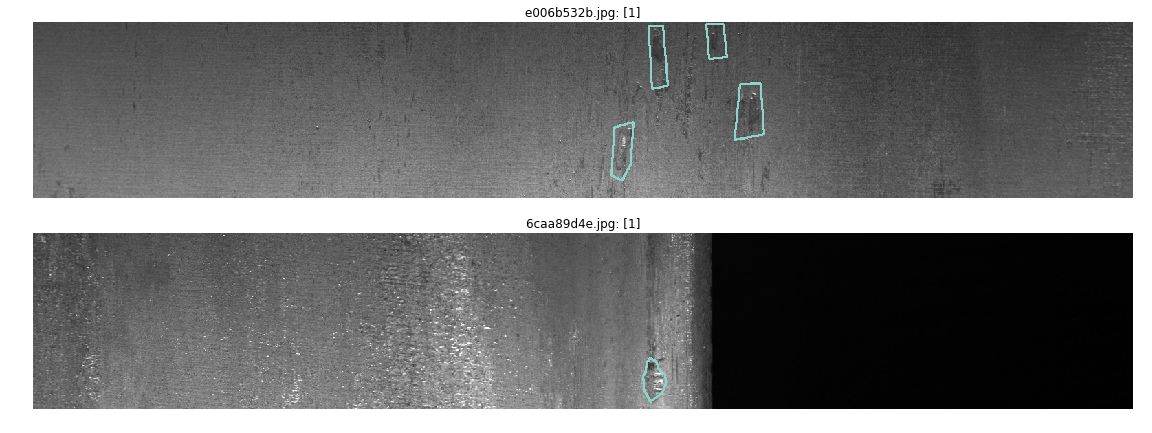

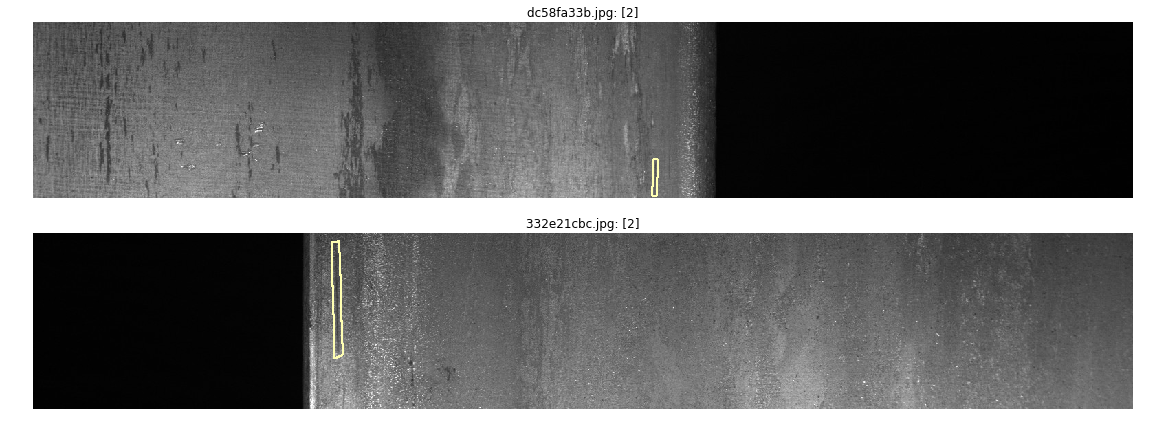

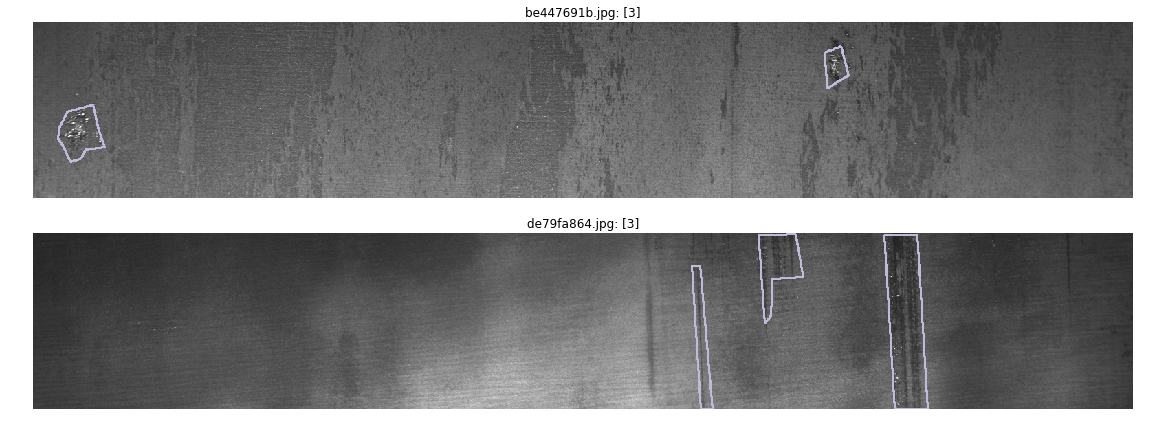

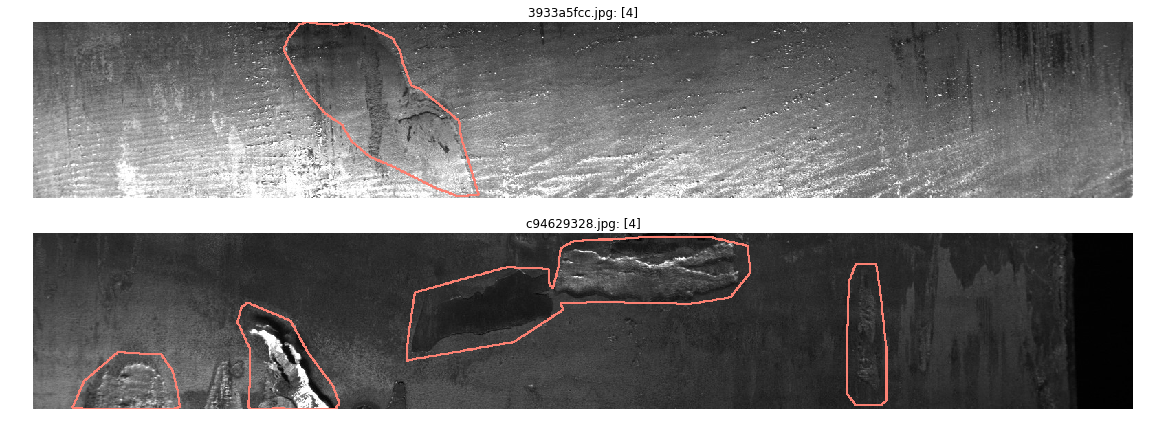

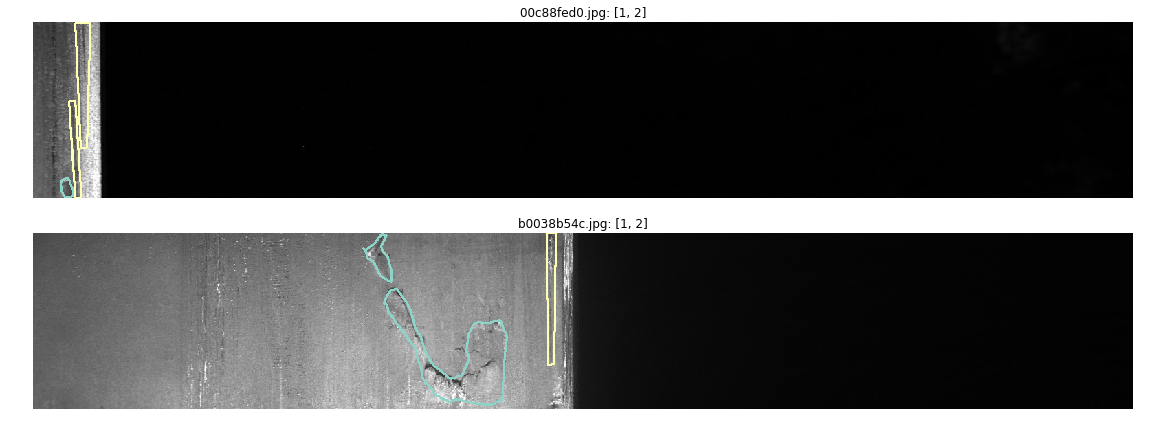

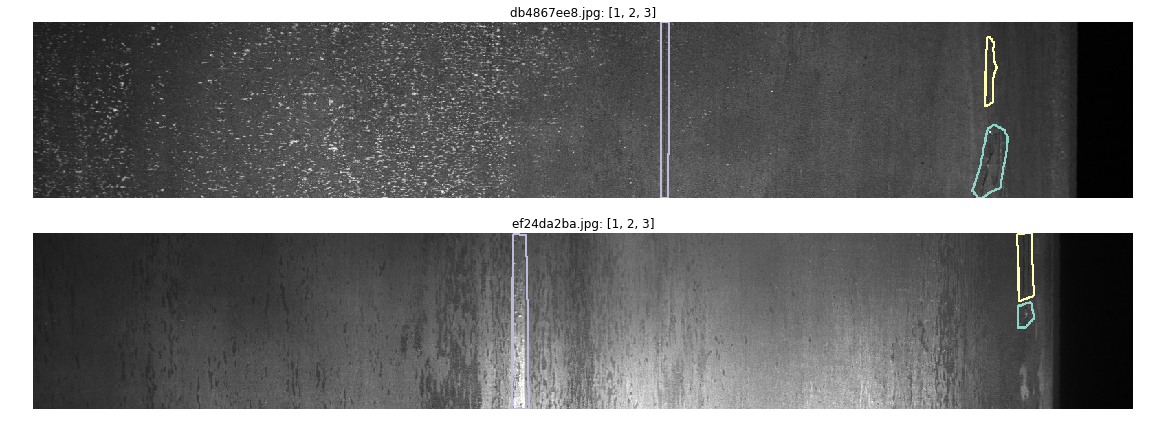

In [19]:
# the images we want to see
conditions = [
    squashed['ClassId'].astype(str)=='[1]',
    squashed['ClassId'].astype(str)=='[2]',
    squashed['ClassId'].astype(str)=='[3]',
    squashed['ClassId'].astype(str)=='[4]',
    squashed['DistinctDefectTypes']==2,
    squashed['DistinctDefectTypes']==3
]

# max 2 due to limited population of [squashed['Distinct Defect Types']==3]
# remove that condition if you wish to increase the sample size, 
# or add replace=True to the .sample() method
sample_size = 2

# looping over the different combinations of labels 
for condition in conditions:
    
    # isolate from dataset and draw a sample
    sample = squashed[condition].sample(sample_size) 
    
    # make a subplot+
    fig, axes = plt.subplots(sample_size, 1, figsize=(16, sample_size*3))
    fig.tight_layout()
    
    # looping over sample
    for i, (index, row) in enumerate(sample.iterrows()):
        
        # current ax
        ax = axes[i,]
        
        # build the mask
        mask = build_mask(encodings=row.EncodedPixels, labels=row.ClassId)

        # fetch the image and draw the contours
        image = visualise_mask(file_name=row.ImageId, mask=mask)
        
        # display
        ax.set_title(f'{row.ImageId}: {row.ClassId}')
        ax.axis('off')
        ax.imshow(image);

<a id="5"></a> <br>
# Semantic Segmentation
Below are some of the common tasks in the field of Machine Vision:
![semantic_segmentation](https://miro.medium.com/max/1838/1*Tb3CvTONAA4IVL-HciJscw.jpeg)

We are dealing with the problem of semantic segmentation: predicting a pixel-by-pixel mask of distinct classes.
Check out Priya Dwivedi's [excellent blogpost](https://towardsdatascience.com/semantic-segmentation-popular-architectures-dff0a75f39d0) on the topic if you want to read more.

<a id="6"></a> <br>
# Mask R-CNN
Mask R-CNN falls under the category of meta-algorithms, rather than purely a neural network architecture. In fact, it builds on the faster R-CNN architecture, so you even have a choice of what neural net 'backbone' you want it to use.

![maskrcnn-framework](https://miro.medium.com/max/1285/1*IWWOPIYLqqF9i_gXPmBk3g.png)


The most important aspects of this algorithm are:
* **FPN (feature pyramid network)** - A fully convolutional neural architecture designed to extract features.
* **RPN (region proposal network)** - A lightweight neural network that scans over the FPN features to suggest ROI (regions of interest)
* **ROIAlign** - a novel way to pass the object to the classifier an mask generator. Contrary to the ROIpool mechanism that was the standard, this one uses [bilinear interpolation](https://www.quora.com/How-does-ROTAlign-work-in-Mask-RCNN) to improve performance significantly.
* **Classifier & Bounding Box Regressor**. 
* **Mask Generator** - A convolutional network that takes the regions selected by the ROI classifier and generates soft masks for them. 

Read more on [Matterport's official blog](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46) <br>
You can also check out the original paper's authors presenting the Mask R-CNN [on YouTube](https://youtu.be/g7z4mkfRjI4)

## Importing
For instructions on how to import models into a Kaggle kernel, check out the following Medium article: [Setting Up Mask-RCNN on Kaggle](https://medium.com/@umdfirecoml/setting-up-mask-rcnn-on-kaggle-34b656140b5e)

2019/10/10: <br> 
This method currently produces an error message when committing. <br> 
```Output path '/Mask_RCNN/.git/logs/refs/remotes/origin/HEAD' contains too many nested subdirectories (max 6)```. <br> 
I resort to Simon Walker's method to get around this.

2019/10/17: <br>
A Keras update means the model now produces an error [documented in issue #1754](https://github.com/matterport/Mask_RCNN/issues/1754). <br>
I therefore cloned the repo and applied a small fix. <br>
```changing: self.keras_model.metrics_tensors.append(loss)
to: self.keras_model.add_metric(loss, name)````


In [20]:
WORKING_DIR = '/kaggle/working'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
MASK_RCNN_DIR = os.path.join(WORKING_DIR, 'Mask_RCNN-master')

In [21]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git 
# results in Commit Error (too many nested subdirectories)

""" Credit to Simon Walker, whose method helped me to 
    circumvent the commit error. Check out his kernel at 
    https://www.kaggle.com/srwalker101/mask-rcnn-model
"""
!pip install git+https://github.com/rteuwens/Mask_RCNN

  Cloning https://github.com/rteuwens/Mask_RCNN to /tmp/pip-req-build-25j21ozu
  Running command git clone -q https://github.com/rteuwens/Mask_RCNN /tmp/pip-req-build-25j21ozu
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-cp36-none-any.whl size=56918 sha256=66fa7db3a445d57676bf629811c65c69d9dcc3cbb510bcff409ef9ffd42968b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-iupgnxby/wheels/34/61/30/3113b1512c979c7072406d2fb5be2e6e8c61fd1e3ec7ca1b48
Successfully built mask-rcnn


In [22]:
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


## Configuring

In [23]:
class SeverstalConfig(Config):

    # Give the configuration a recognizable name
    NAME = "severstal"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + steel defects

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # Discard inferior model weights
    SAVE_BEST_ONLY = True
    
# instantiating 
severstal_config = SeverstalConfig()

In [24]:
# super class can be found here:
# https://github.com/matterport/Mask_RCNN/blob/v2.1/utils.py

class SeverstalDataset(Dataset):
    
    def __init__(self, dataframe):
        
        # https://rhettinger.wordpress.com/2011/05/26/super-considered-super/
        super().__init__(self)
        
        # needs to be in the format of our squashed df, 
        # i.e. image id and list of rle plus their respective label on a single row
        self.dataframe = dataframe
        
    def load_dataset(self, subset='train'):
        """ takes:
                - pandas df containing 
                    1) file names of our images 
                       (which we will append to the directory to find our images)
                    2) a list of rle for each image 
                       (which will be fed to our build_mask() 
                       function we also used in the eda section)         
            does:
                adds images to the dataset with the utils.Dataset's add_image() metho
        """
        
        # input hygiene
        assert subset in ['train', 'test'], f'"{subset}" is not a valid value.'
        img_folder = img_train_folder if subset=='train' else img_test_folder
        
        # add our four classes
        for i in range(1,5):
            self.add_class(source='', class_id=i, class_name=f'defect_{i}')
        
        # add the image to our utils.Dataset class
        for index, row in self.dataframe.iterrows():
            file_name = row.ImageId
            file_path = f'{img_folder}/{file_name}'
            
            assert os.path.isfile(file_path), 'File doesn\'t exist.'
            self.add_image(source='', 
                           image_id=file_name, 
                           path=file_path)
    
    def load_mask(self, image_id):
        """As found in: 
            https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/coco.py
        
        Load instance masks for the given image
        
        This function converts the different mask format to one format
        in the form of a bitmap [height, width, instances]
        
        Returns:
            - masks    : A bool array of shape [height, width, instance count] with
                         one mask per instance
            - class_ids: a 1D array of class IDs of the instance masks
        """
        
        # find the image in the dataframe
        row = self.dataframe.iloc[image_id]
        
        # extract function arguments
        rle = row['EncodedPixels']
        labels = row['ClassId']
        
        # create our numpy array mask
        mask = build_mask(encodings=rle, labels=labels)
        
        # we're actually doing semantic segmentation, so our second return value is a bit awkward
        # we have one layer per class, rather than per instance... so it will always just be 
        # 1, 2, 3, 4. See the section on Data Shapes for the Labels.
        return mask.astype(np.bool), np.array([1, 2, 3, 4], dtype=np.int32)

## Train/Test Split

In [25]:
from sklearn.model_selection import train_test_split

# stratified split to maintain the same class balance in both sets
train, validate = train_test_split(squashed, test_size=0.2, random_state=RANDOM_SEED)

We now have a validation set that has the same class distribution as the training set.

In [26]:
print(train['ClassId'].astype(str).value_counts(normalize=True))
print('')
print(validate['ClassId'].astype(str).value_counts(normalize=True))

[3]          0.716992
[1]          0.112716
[4]          0.076144
[3, 4]       0.041448
[2]          0.031133
[1, 3]       0.012566
[1, 2]       0.006189
[2, 3]       0.002251
[1, 2, 3]    0.000375
[2, 4]       0.000188
Name: ClassId, dtype: float64

[3]       0.701649
[1]       0.125937
[4]       0.082459
[3, 4]    0.047226
[2]       0.021739
[1, 3]    0.017991
[1, 2]    0.001499
[2, 3]    0.001499
Name: ClassId, dtype: float64


In [27]:
%%time

# instantiating training set
dataset_train = SeverstalDataset(dataframe=train)
dataset_train.load_dataset()
dataset_train.prepare()

# instantiating validation set
dataset_validate = SeverstalDataset(dataframe=validate)
dataset_validate.load_dataset()
dataset_validate.prepare()

CPU times: user 1.44 s, sys: 303 ms, total: 1.74 s
Wall time: 7.66 s


## Pre-Trained Weights

In [28]:
!curl -LO https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   656  100   656    0     0   5125      0 --:--:-- --:--:-- --:--:--  5125
100  245M  100  245M    0     0  70.7M      0  0:00:03  0:00:03 --:--:-- 78.2M


## Instantiating the Model

In [29]:
# configuration
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# session stuff
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

# initialiazing model
model = MaskRCNN(mode='training', config=severstal_config, model_dir='modeldir')

# we will retrain starting with the coco weights
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=['mrcnn_bbox_fc',
                            'mrcnn_class_logits', 
                            'mrcnn_mask',
                            'mrcnn_bbox'])

<a id="7"></a> <br>
# Training

In [30]:
%%time 

# ignore UserWarnongs
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# training at last
model.train(dataset_train,
            dataset_validate,
            epochs=1,
            layers='heads',
            learning_rate=severstal_config.LEARNING_RATE)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: modeldir/severstal20220330T1919/mask_rcnn_severstal_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

# To-Do
* Split kernels into training & inference
* "Squashed" DataFrame for inference on the competition set
* Improving the model

Have fun!